In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("Train.csv")
train['Datetime'] = pd.to_datetime(train.Datetime, format='%Y/%m/%d')
test = pd.read_csv("Test.csv")
test['Datetime'] = pd.to_datetime(test.Datetime, format='%Y/%m/%d')

# train = np.asarray(df_train.iloc[:,1])
# test = np.asarray(df_test.iloc[:,1])

# 一阶差分

In [3]:
new=train.diff(periods=1).dropna()
newtest=test.diff(periods=1).dropna()

In [4]:
new,newtest

(     Datetime  DailyMinimumDryBulbTemperature
 1      1 days                            -9.0
 2      1 days                            -7.0
 3      1 days                            -2.0
 4      1 days                             5.0
 5      1 days                             7.0
 ...       ...                             ...
 2871   1 days                            -4.0
 2872   1 days                             0.0
 2873   1 days                            11.0
 2874   1 days                            -3.0
 2875   1 days                             2.0
 
 [2875 rows x 2 columns],
     Datetime  DailyMinimumDryBulbTemperature
 1     1 days                             3.0
 2     1 days                             0.0
 3     1 days                            -7.0
 4     1 days                             1.0
 5     1 days                            15.0
 ..       ...                             ...
 715   1 days                             4.0
 716   1 days                           

# 平稳性检验

In [5]:
dftest = adfuller(new['DailyMinimumDryBulbTemperature'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -21.156549
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    2860.000000
Critical Value (1%)              -3.432639
Critical Value (5%)              -2.862551
Critical Value (10%)             -2.567308
dtype: float64


# ACF PACF图形定阶

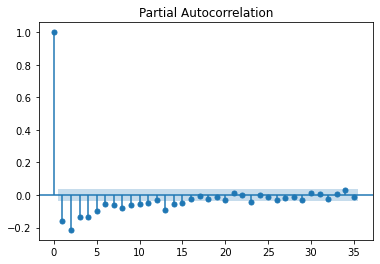

In [6]:
plot_pacf(new['DailyMinimumDryBulbTemperature'])
plt.show()

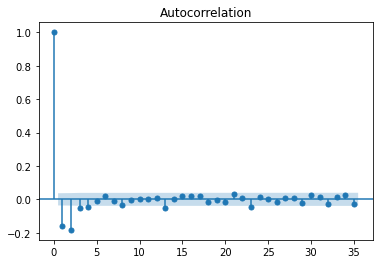

In [7]:
plot_acf(new['DailyMinimumDryBulbTemperature'])
plt.show()

In [8]:
# model = AR(train['DailyMinimumDryBulbTemperature'])
x =ar_select_order(new['DailyMinimumDryBulbTemperature'],20,ic='bic')
x.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [9]:
model = AR(new['DailyMinimumDryBulbTemperature'],train['Datetime'])
res=model.fit(maxlag = 15,ic='bic')
res.k_ar

14

### 通过图形定阶、信息准则等方法，我们将参数p选为14

In [10]:
ar = AutoReg(new['DailyMinimumDryBulbTemperature'],lags=14,trend='n',seasonal=True,period=365).fit() 
ar_fit = ar.predict(start=14,end=len(train)-2) 
ar_pre = ar.predict(start=len(train),end=len(train)+len(test)-1)  # 这里是预测了

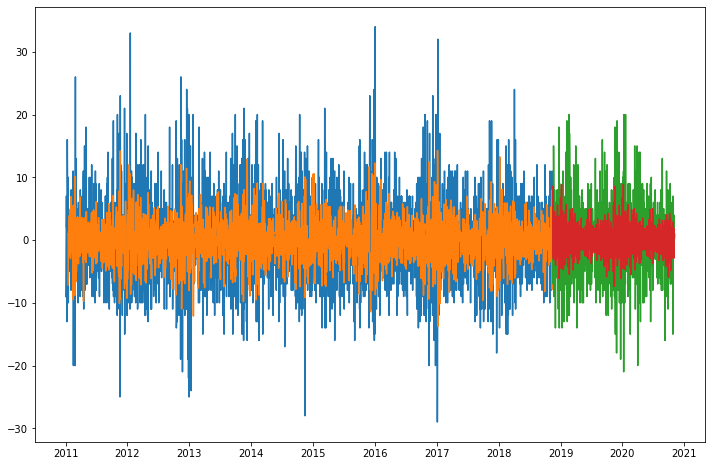

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(train.Datetime[1:], new['DailyMinimumDryBulbTemperature'], label='Train')
plt.plot(train.Datetime[15:], ar_fit, label='AR fit') 
plt.plot(test.Datetime[1:], newtest['DailyMinimumDryBulbTemperature'], label='Test')
plt.plot(test.Datetime, ar_pre, label='AR predict')
plt.show()

In [12]:
dfa=pd.concat([train.Datetime[1:],new['DailyMinimumDryBulbTemperature']],axis=1)

In [13]:
arPre=ar_pre.reset_index().drop('index',axis=1)
arPre.columns=["DailyMinimumDryBulbTemperature"]

In [14]:
dfb=pd.concat([test.Datetime,arPre],axis=1)

In [15]:
dfc=pd.concat([dfa,dfb],ignore_index=True)
dfc.set_index('Datetime',inplace=True)

# 将差分数据恢复原始比例

In [16]:
# 我们将预测部分的数据恢复原始状态后，与test数据集做对比，并算出MSE。
df_diff_cumsum = dfc.cumsum()

In [17]:
new_train=train.set_index('Datetime')
df=new_train.iloc[0:1]

In [18]:
def add(x):
    return x+16

In [19]:
df_diff_cumsum['DailyMinimumDryBulbTemperature']=df_diff_cumsum['DailyMinimumDryBulbTemperature'].map(add)
df_diff_cumsum

,DailyMinimumDryBulbTemperature
Datetime,
2011-01-02,7.000000
2011-01-03,0.000000
2011-01-04,-2.000000
2011-01-05,3.000000
2011-01-06,10.000000
...,...
2020-10-31,17.848491
2020-11-01,14.973491
2020-11-02,16.848491


In [20]:
df_res=pd.concat([df,df_diff_cumsum])
df_res # 得到还原后表格

,DailyMinimumDryBulbTemperature
Datetime,
2011-01-01,16.000000
2011-01-02,7.000000
2011-01-03,0.000000
2011-01-04,-2.000000
2011-01-05,3.000000
...,...
2020-10-31,17.848491
2020-11-01,14.973491
2020-11-02,16.848491


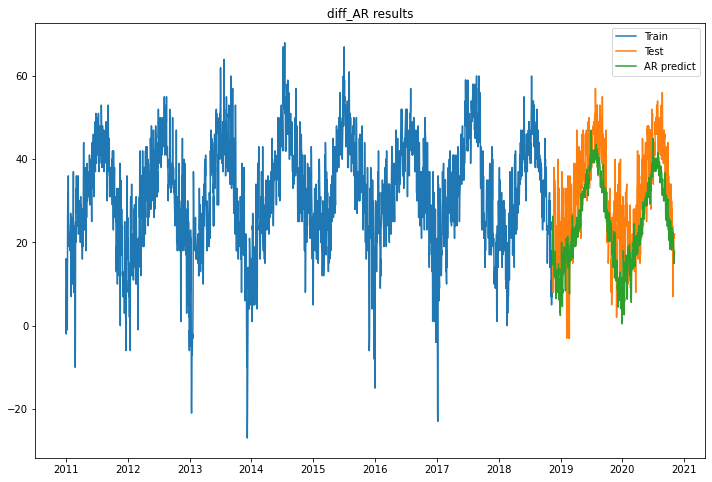

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(train.Datetime, train['DailyMinimumDryBulbTemperature'], label='Train')
plt.plot(test.Datetime, test['DailyMinimumDryBulbTemperature'], label='Test')
plt.plot(test.Datetime, df_res[2876:]['DailyMinimumDryBulbTemperature'], label='AR predict')
plt.legend(loc='best')
plt.title('diff_AR results')
plt.show()

In [22]:
mse = mean_squared_error(test.DailyMinimumDryBulbTemperature, df_res[2876:].DailyMinimumDryBulbTemperature)
rmse = sqrt(mean_squared_error(test.DailyMinimumDryBulbTemperature, df_res[2876:].DailyMinimumDryBulbTemperature))
mse,rmse

(111.29482649508007, 10.549636320512668)